|        |         |                                @ |
|:-------|:--------|---------------------------------:|  
| Luca   | Mosetti | luca.mosetti-1@studenti.unitn.it |  
| Shandy | Darma   |   shandy.darma@studenti.unitn.it |

In [1]:
import numpy as np
import more_itertools as mit

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

import scipy.stats as st

# Exercise 2 (facultative)

Compare different Monte-Carlo methods for the estimation of π. In particular compare the following:
1. The naive estimator that computes π/4 as the ratio of points within a circle of radius equal to 1 centered on (0, 0) to the total number of points drawn at random within a square of side length 2, also centered on (0, 0);
2. The improved estimator seen in class that exploits conditioning and antithetic random numbers;
3. The improved estimator seen in class that exploits conditioning, antithetic random numbers, and stratifi- cation.

Set your preferred stopping rules in terms of
- the number of correct digits of π estimated by your method;
- the size of the 95% confidence interval for the estimated value of π.

Show how many iterations the above methods need in each case.

For each of the three above Monte-Carlo methods, it may also be curious to check the histogram of the values you compute the sample average of.

In [2]:
pi_digits = 4
conf_interval_size = 1e-4

**First method**: The naive estimator that computes π/4 as the ratio of points within a circle of radius equal to 1 centered on (0, 0) to the total number of points drawn at random within a square of side length 2, also centered on (0, 0)

Let
$$
U_{1}, U_{2} \sim \text{Uniform}
$$

generated by different random number generator.

Then
$$
V_{1} = 2U_{1} - 1\\
V_{2} = 2U_{2} - 1\\
I=\begin{cases}
    1, & \text{if } V_{1}^{2} + V_{2}^{2} \leq 1\\
    0, & \text{otherwise}
\end{cases}\\
E[I] = P\{V_{1}^{2} + V_{2}^{2} \leq 1\} = \frac{\pi}{4}
$$

In [3]:
def generate(seed_x, seed_y, pi_digits):
    rng_x = np.random.default_rng(seed_x)
    rng_y = np.random.default_rng(seed_y)

    result = 0
    estimated_pi = 0.0
    expected_pi = int(np.pi * (10 ** (pi_digits-1)))

    random_numbers_x, random_numbers_y, random_numbers = np.array([]), np.array([]), np.array([])

    while (int(estimated_pi * (10 ** (pi_digits-1))) != expected_pi):
        random_number_x = (rng_x.random() * 2) - 1
        random_number_y = (rng_y.random() * 2) - 1

        random_number = (random_number_x ** 2) + (random_number_y ** 2) <= 1
        random_numbers = np.append(random_numbers, random_number)

        estimated_pi = np.mean(random_numbers) * 4
        
    return [len(random_numbers), estimated_pi]

In [4]:
seeds = mit.sieve(1_000_000)
next(seeds)

conf_interval = None
attempts_1 = []
estimations_1 = []

while (len(estimations_1) < 2 or conf_interval[1] - conf_interval[0] > conf_interval_size):
    seed_x, seed_y = next(seeds), next(seeds)
    attempt, estimation = generate(seed_x, seed_y, pi_digits)
    
    attempts_1.append(attempt)
    estimations_1.append(estimation)
    
    conf_interval = st.t.interval(0.95, len(estimations_1)-1, loc=np.mean(estimations_1), scale=st.sem(estimations_1))

/Users/shandydarma/.virtualenvs/hw_sape/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/shandydarma/.virtualenvs/hw_sape/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


**Second method:** The improved estimator seen in class that exploits conditioning and antithetic random numbers

From previous method, we define:

$$
I=\begin{cases}
    1, & \text{if } V_{1}^{2} + V_{2}^{2} \leq 1\\
    0, & \text{otherwise}
\end{cases}\\
$$

Now, the estimator is improved by using conditioning:

$$
\begin{align}
    E[I|V_{1} = x] &= P\{X^{2} + Y^{2} \leq 1 | V_{1} = v\} \\
    &= P\{v^{2} + Y^{2} \leq 1 | V_{1} = v\} & \text{replace $V_{1}$ with $v$} \\
    &= P\{V_{2}^{2} \leq 1 - v^{2}\} & \text{because $V_{1}$ and $V_{2}$ are independent} \\
    &= P\{-(1-v^{2})^{1/2} \leq V_{2} \leq (1-v^{2})^{1/2} \} & \text{inequality} \\
    &= \int_{-(1-v^{2})^{1/2}}^{(1-v^{2})^{1/2}} \left(\frac{1}{2}\right) \, dx \\
    &= (1-v^{2})^{1/2} \\
    &= (1-V_{1}^{2})^{1/2} \\
\end{align}
$$

The new estimator can be further simplified:

$$
\begin{align}
    E[(1-V_{1}^{2})^{1/2}] &= \int_{-1}^{1} (1-x^{2})^{1/2} \left(\frac{1}{2}\right) \, dx \\
    &= \int_{0}^{1} (1-x^{2})^{1/2} \, dx \\
    &= E[(1-U^{2})^{1/2}]
\end{align}
$$

Furthermore, since $(1-U^{2})^{1/2}$ is a monotonic function, it can be improved with antithetic random numbers to be:

$$
\frac{1}{2}[(1-U^{2})^{1/2} + (1-(1-U)^{2})^{1/2}]
$$

In [5]:
def generate_with_conditioning_antithetic(seed, pi_digits):
    rng = np.random.default_rng(seed)

    estimated_pi = 0.
    expected_pi = int(np.pi * (10 ** (pi_digits-1)))
    uniforms = np.array([])

    while (int(estimated_pi * (10 ** (pi_digits-1))) != expected_pi):
        u = rng.random()
        uniforms = np.append(uniforms, u)
        estimated_pi = np.mean((np.sqrt(1 - (uniforms ** 2)) + np.sqrt(1 - ((1 - uniforms) ** 2)))) * 2
        
    return (len(uniforms), estimated_pi)

In [6]:
seeds = mit.sieve(1_000_000)
next(seeds)

conf_interval = None
attempts_2 = []
estimations_2 = []

while (len(estimations_2) < 2 or conf_interval[1] - conf_interval[0] > conf_interval_size):
    seed = next(seeds)
    attempt, estimation = generate_with_conditioning_antithetic(seed, pi_digits)
    
    attempts_2.append(attempt)
    estimations_2.append(estimation)
    
    conf_interval = st.t.interval(0.95, len(estimations_2)-1, loc=np.mean(estimations_2), scale=st.sem(estimations_2))

**Third method:** The improved estimator seen in class that exploits conditioning, antithetic random numbers, and stratification.

The estimator from previous method:

$$
\frac{1}{2}[(1-U^{2})^{1/2} + (1-(1-U)^{2})^{1/2}]
$$

Can be improved further using stratification.

$$
\pi \approx \frac{2}{n} \sum_{j=1}^{n}\left[\sqrt{1-\left(\frac{U_{j}+j-i}{n}\right)^{2}} + \sqrt{1-\left(\frac{j-U_{j}}{n}\right)^{2}}\right] \\
$$

In [7]:
def generate_with_conditioning_antithetic_stratification(seed, pi_digits):
    rng = np.random.default_rng(seed)

    estimated_pi = 0.
    expected_pi = int(np.pi * (10 ** (pi_digits-1)))
    uniforms = np.array([])

    while (int(estimated_pi * (10 ** (pi_digits-1))) != expected_pi):
        u = rng.random()
        uniforms = np.append(uniforms, u)
        n = len(uniforms)
        j = np.arange(1, n+1)
        estimated_pi = np.mean(np.sqrt(1 - (((u + j - 1)/n) ** 2)) + np.sqrt(1 - ((j - u)/n) ** 2)) * 2

    return (len(uniforms), estimated_pi)

In [8]:
seeds = mit.sieve(1_000_000)

conf_interval = None
attempts_3 = []
estimations_3 = []

while (len(estimations_3) < 2 or conf_interval[1] - conf_interval[0] > conf_interval_size):
    seed = next(seeds)
    attempt, estimation = generate_with_conditioning_antithetic_stratification(seed, pi_digits)
    
    attempts_3.append(attempt)
    estimations_3.append(estimation)
    
    conf_interval = st.t.interval(0.95, len(estimations_3)-1, loc=np.mean(estimations_3), scale=st.sem(estimations_3))

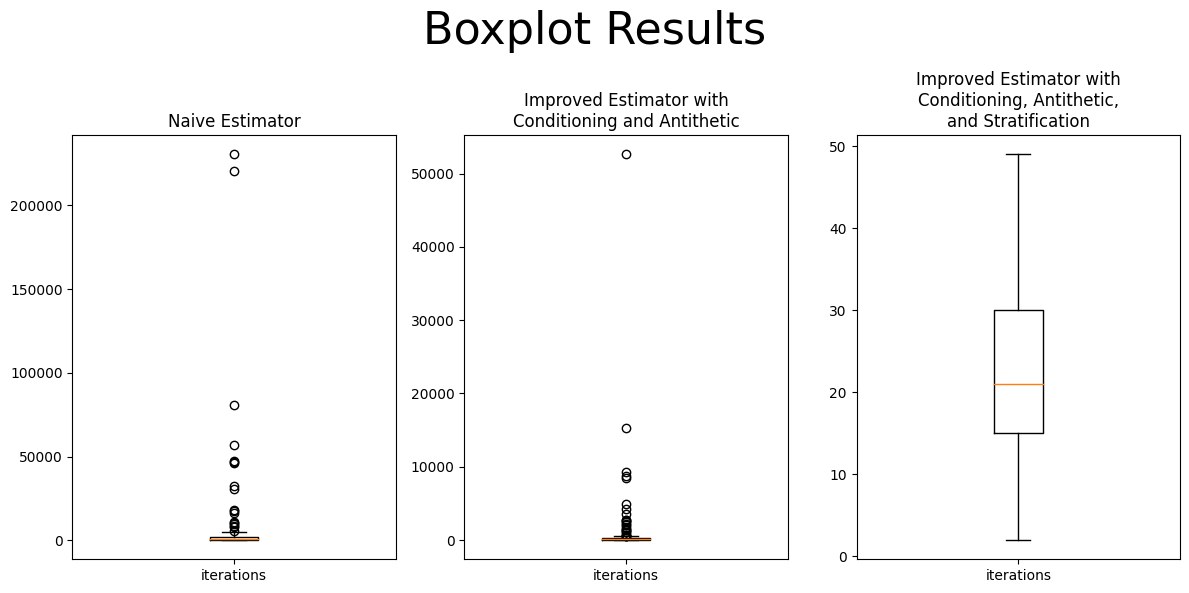

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
ax1.boxplot(attempts_1, labels=["iterations"])
ax1.title.set_text("Naive Estimator")
ax2.boxplot(attempts_2, labels=["iterations"])
ax2.title.set_text("Improved Estimator with\nConditioning and Antithetic")
ax3.boxplot(attempts_3, labels=["iterations"])
ax3.title.set_text("Improved Estimator with\nConditioning, Antithetic,\nand Stratification")

fig.suptitle("Boxplot Results", fontsize=32)
fig.tight_layout()

plt.show()

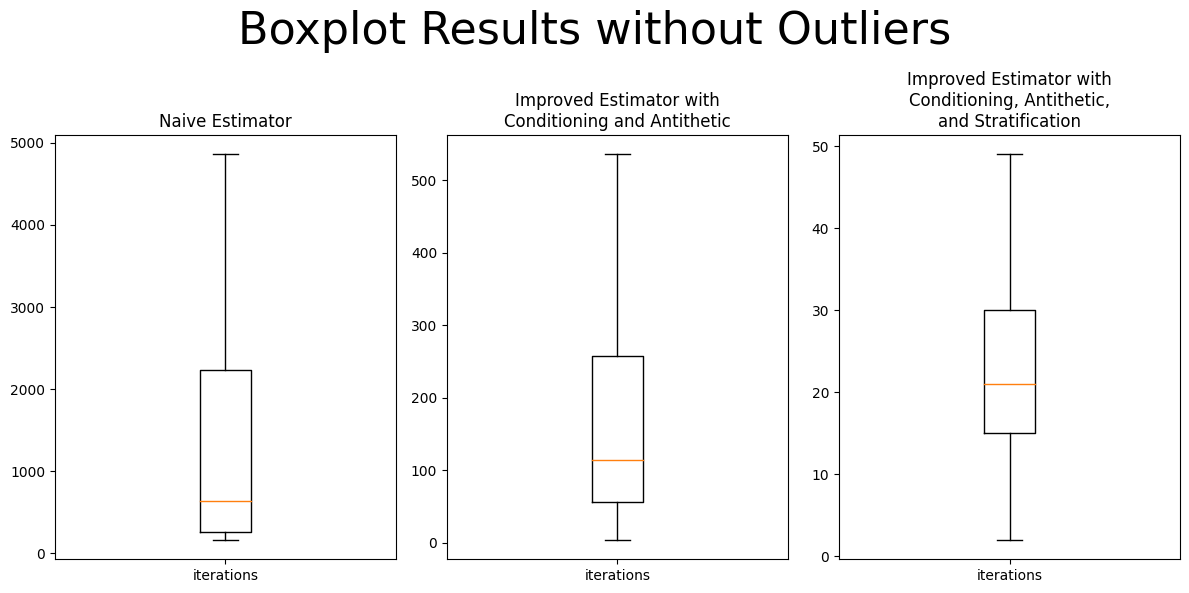

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
ax1.boxplot(attempts_1, labels=["iterations"], showfliers=False)
ax1.title.set_text("Naive Estimator")
ax2.boxplot(attempts_2, labels=["iterations"], showfliers=False)
ax2.title.set_text("Improved Estimator with\nConditioning and Antithetic")
ax3.boxplot(attempts_3, labels=["iterations"], showfliers=False)
ax3.title.set_text("Improved Estimator with\nConditioning, Antithetic,\nand Stratification")

fig.suptitle("Boxplot Results without Outliers", fontsize=32)
fig.tight_layout()

plt.show()